In [1]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_settings_v3 import *
from plot_auxiliary import *
from planar import create_proximity_graph
from auxiliary import get_base_network_name
from auxiliary import getLinearReg

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

### Determination of the percolation threshold using the crossing method

BtwU_cutoff2        0.34089 +- 0.00074  0.002166
BtwU_cutoff3        0.28771 +- 0.00111  0.003869
BtwU_cutoff4        0.26255 +- 0.00218  0.008302
BtwU_cutoff5        0.24166 +- 0.00283  0.011700
BtwU_cutoff6        0.22381 +- 0.00219  0.009772
BtwU_cutoff7        0.21020 +- 0.00438  0.020838
BtwU_cutoff8        0.20778 +- 0.00724  0.034860
BtwU_cutoff9        0.19293 +- 0.00678  0.035164
BtwU_cutoff10       0.19948 +- 0.00054  0.002706
BtwU_cutoff11       0.19948 +- 0.00054  0.002706
BtwU_cutoff12       0.19525 +- 0.00728  0.037280
BtwU_cutoff13       0.17885 +- 0.00870  0.048618
BtwU_cutoff14       0.16453 +- 0.00772  0.046939
BtwU_cutoff15       0.16249 +- 0.01545  0.095086


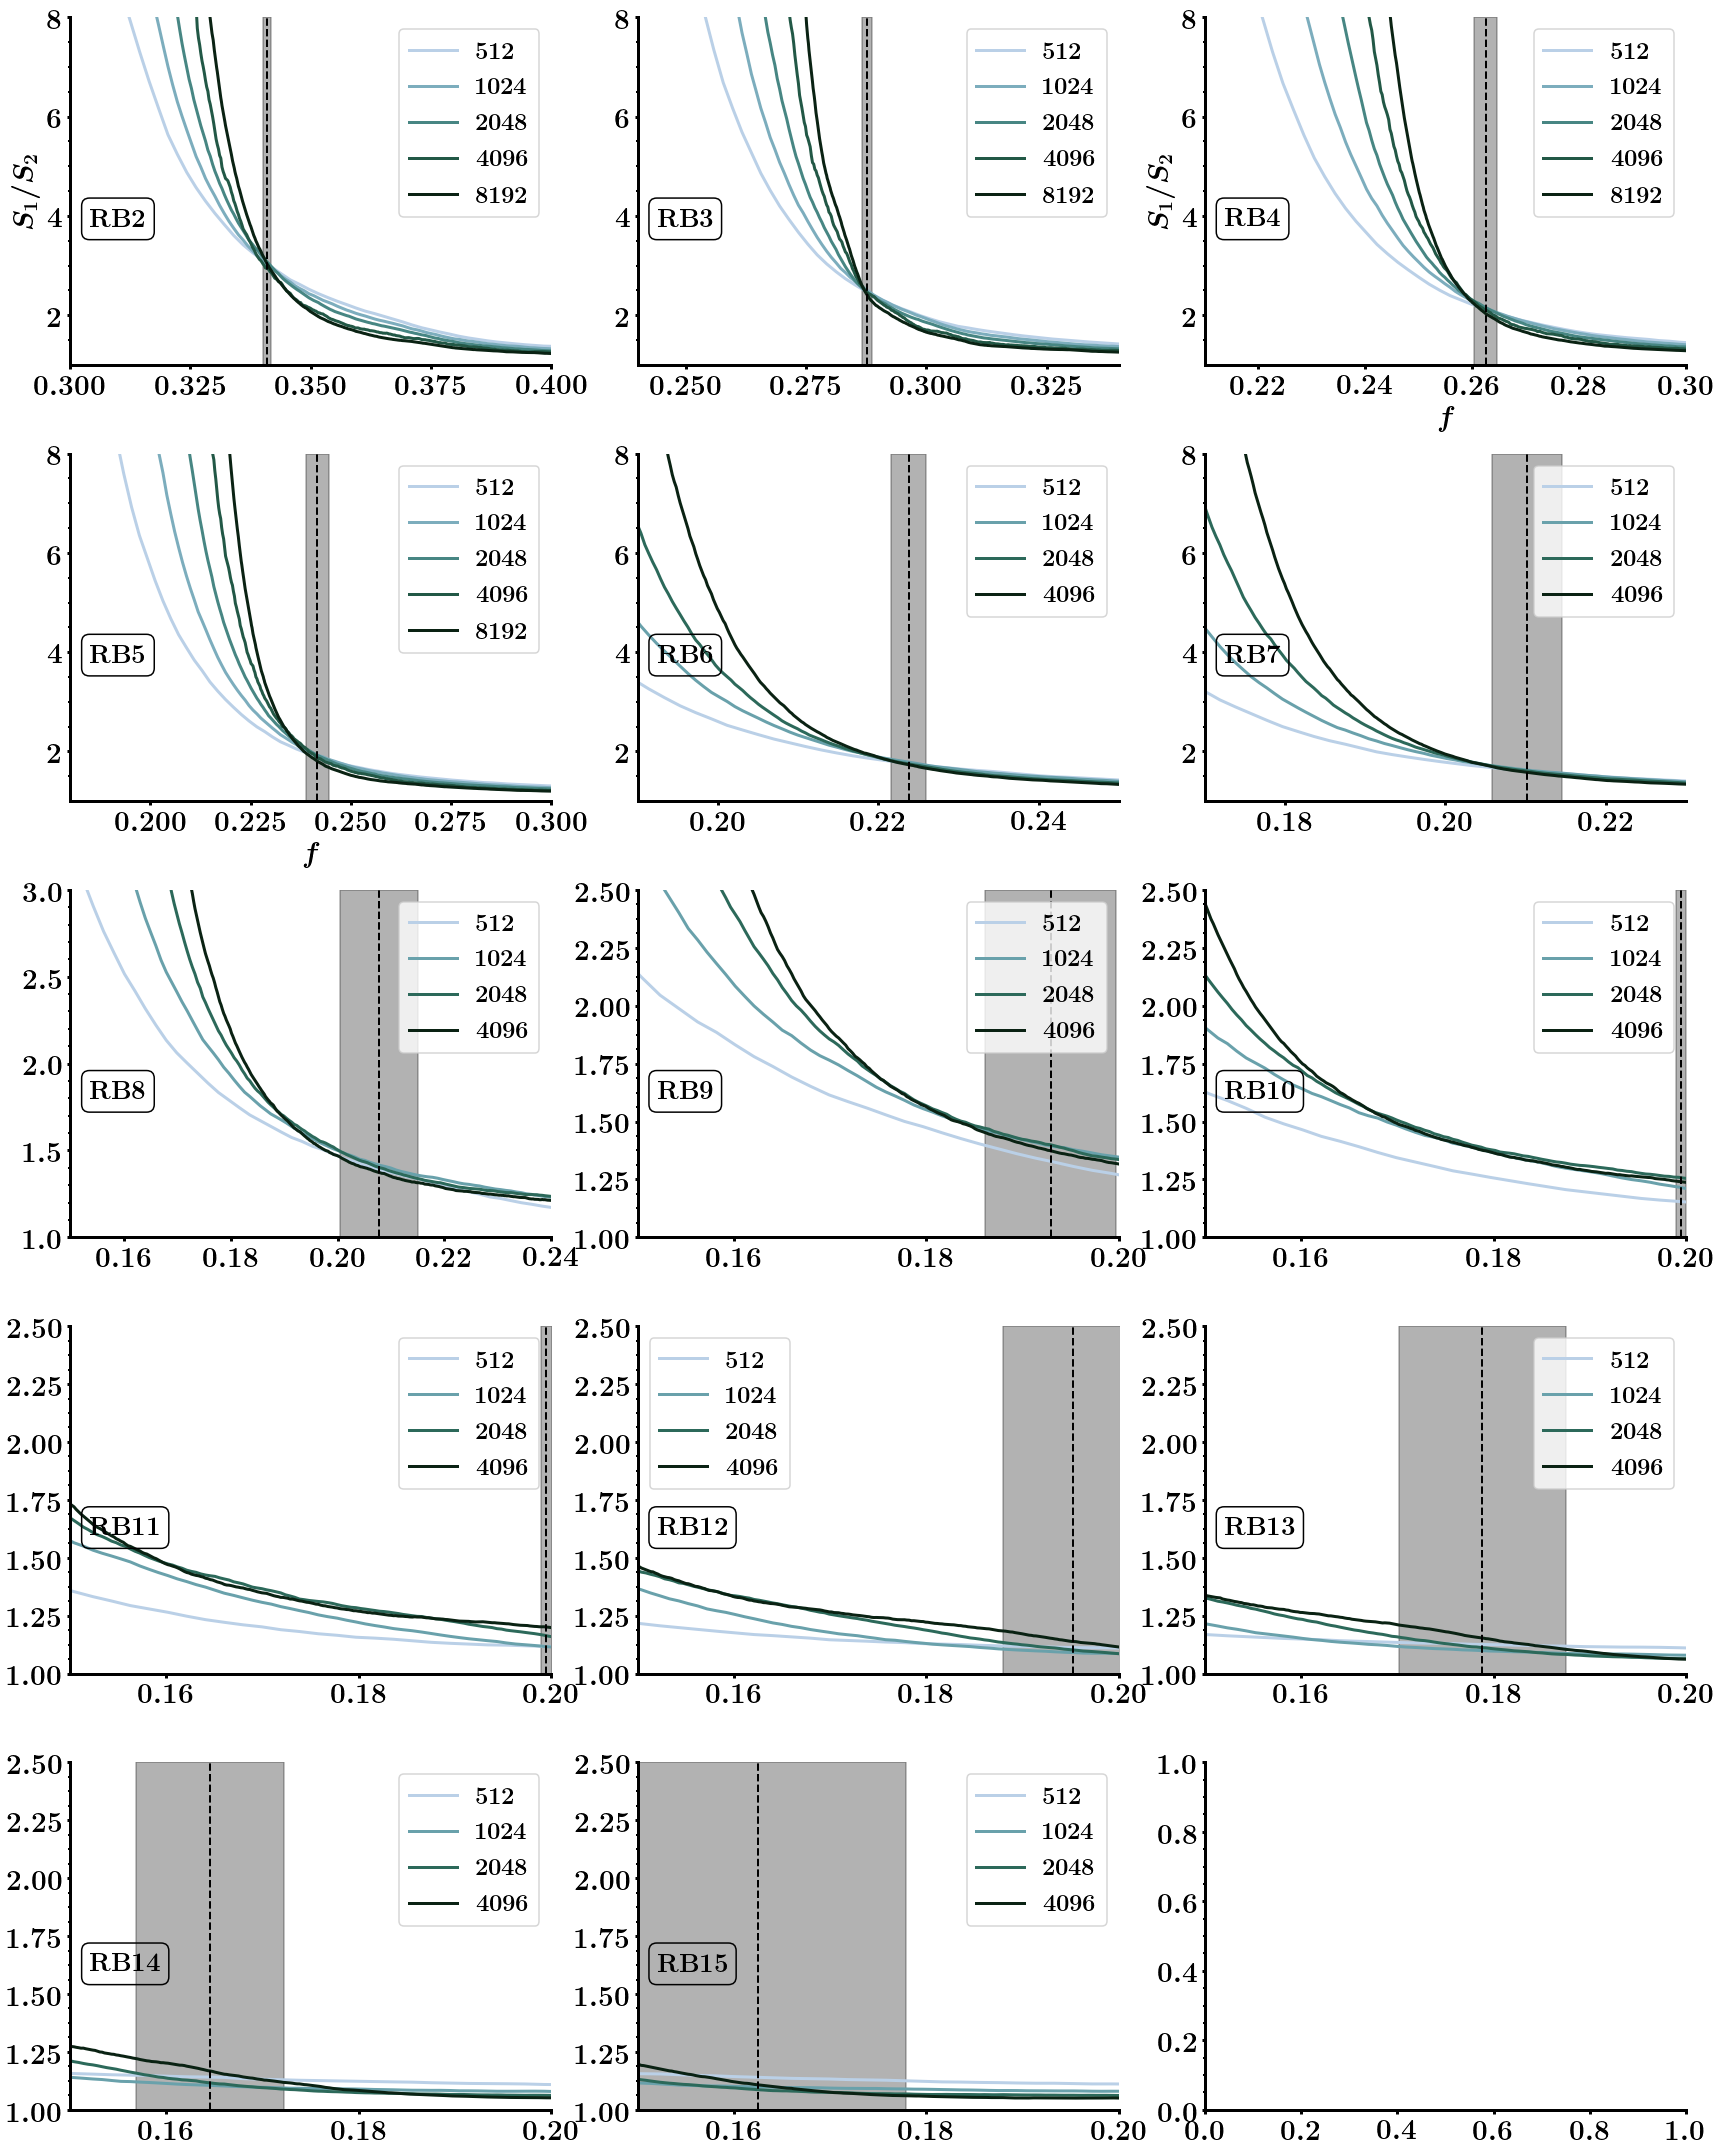

In [2]:
def plot_S1_over_S2(net_type):

    l_values = range(2, 16)
    attacks = ['BtwU_cutoff%d' % l for l in l_values] #+ ['DegU', 'BtwU', 'CIU']
    
    ncols = 3
    nrows = len(attacks) // ncols 
    if len(attacks) % ncols:
        nrows += 1
    fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    fc_values = {}
    for j, attack in enumerate(attacks):

        sizes = [512, 1024, 2048, 4096, 8192, 16384]  
        #if l > 7:
        #    sizes = sizes[1:]
        dfs = {}
        for N in sizes:
            try:
                dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=10000)
            except FileNotFoundError:
                continue

        N_values = np.sort(list(dfs.keys()))
        L_values = np.sqrt(N_values)
        
        ax = axes[j]
        if attack == 'Ran':
            fmin = 0.4
            fmax = 0.8
            ymin = 1.
            ymax = 5.       

        if attack == 'DegU':
            fmin = 0.35
            fmax = 0.4
            ymin = 1.4
            ymax = 8
            
        if attack == 'BtwU':
            fmin = 0.
            fmax = 0.1
            ymin = 1.
            ymax = 4.0
            
        if attack == 'BtwU_cutoff2':
            fmin = 0.3
            fmax = 0.4
            ymin = 1.
            ymax = 8.0
            
        if attack == 'BtwU_cutoff3':
            fmin = 0.24
            fmax = 0.34
            ymin = 1.
            ymax = 8.0
            
        if attack == 'BtwU_cutoff4':
            fmin = 0.21
            fmax = 0.3
            ymin = 1.
            ymax = 8.0
            
        if attack == 'BtwU_cutoff5':
            fmin = 0.18
            fmax = 0.3
            ymin = 1.
            ymax = 8.0

        if attack == 'BtwU_cutoff6':
            fmin = 0.19
            fmax = 0.25
            ymin = 1.
            ymax = 8.0
            
        if attack == 'BtwU_cutoff7':
            fmin = 0.17
            fmax = 0.23
            ymin = 1.
            ymax = 8.0
            
        if attack == 'BtwU_cutoff8':
            fmin = 0.15
            fmax = 0.24
            ymin = 1.
            ymax = 3.0
            
        if attack == 'BtwU_cutoff9':
            fmin = 0.15
            fmax = 0.20
            ymin = 1.
            ymax = 2.5
        
        large_l_attacks = [
            'BtwU_cutoff9', 'BtwU_cutoff10', 'BtwU_cutoff11', 'BtwU_cutoff12', 
            'BtwU_cutoff13', 'BtwU_cutoff14', 'BtwU_cutoff15', 
        ]
        if attack in large_l_attacks:
            fmin = 0.15
            fmax = 0.20
            ymin = 1.
            ymax = 2.5
             
        if attack == 'CIU':
            fmin = 0.35
            fmax = 0.4
            ymin = 1.
            ymax = 8.0
            
        ax.set_xlim(fmin, fmax)
        if attack == 'BtwU':
            ax.set_yscale('log')
        else:
            ax.set_ylim(ymin, ymax)
            
        if j in [0, 2]:
            ax.set_ylabel(r'$S_1/S_2$', fontsize=28)
        if j in [2, 3]:
            ax.set_xlabel(r'$f$', fontsize=28)

        colors = sns.cubehelix_palette(len(N_values), start=2, rot=0.3, 
                                       light=0.8, dark=0.1)
        for i, N in enumerate(N_values):

            df = dfs[N]
            S1_over_S2 = N * df.Sgcc / df.Nsec
            ax.plot(df.f, S1_over_S2, '-', label=r'${{{}}}$'.format(N), color=colors[i])
        
        if not dfs: ## Dict is empty
            continue

        mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, only_next=False, verbose=False)
        
        fc_values[attack] = (mean_fc, std_fc)
        
        print('{:20}{:.5f} +- {:.5f}{:10f}'.format(attack, mean_fc, std_fc, std_fc/mean_fc))
        
        ax.axvline(mean_fc, linestyle='--', color='k', linewidth=2)
        ax.fill_betweenx([ymin, ymax], mean_fc-std_fc, mean_fc+std_fc, color='k', alpha=0.3)
    
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.04, 0.4, attack_dict[attack], fontsize=26, transform=ax.transAxes, bbox=bbox, 
                horizontalalignment='left')
        #ax.text(0.04, 0.12, letters[j], fontsize=36, transform=ax.transAxes, 
        #        horizontalalignment='left')
        ax.legend(loc='best', fontsize=24)

    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'crossing_method_' + net_type)
    plt.savefig(fig_name + '.png')
    plt.savefig(fig_name + '.pdf')
    
    plt.show()
    
    return fc_values
    
net_type = 'DT'
fc_values = plot_S1_over_S2(net_type=net_type)

### Percolation threshold vs cutoff length

-0.37+-0.01


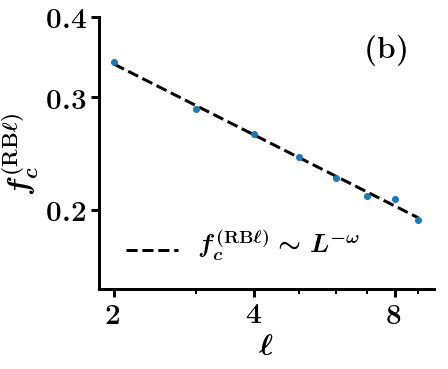

In [10]:
l_values = range(2, 10)
_l_values = []
mean_fc_values = []
for l in l_values:
    attack = 'BtwU_cutoff%d' % l
    if attack in fc_values:
        mean_fc, std_fc = fc_values[attack]
        
        _l_values.append(l)
        mean_fc_values.append(mean_fc)
        
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_ylabel(r'$f_c^{(\mathrm{RB}\ell)}$')
ax.set_xlabel(r'$\ell$')
ax.set_xscale('log')
ax.set_yscale('log')

X, Y = _l_values, mean_fc_values

Y_pred, slope, y_err = getLinearReg(X, Y)
c = Y[0] / X[0]**slope
#label = r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
print('{:.2f}+-{:.2f}'.format(slope, y_err))
label = r'$f_c^{(\mathrm{RB}\ell)} \sim L^{-\omega}$'
ax.plot(X, Y_pred, '--', color='k', label=label)
ax.plot(X, Y, 'o')
ax.text(0.8, 0.85, letters[1], transform=ax.transAxes, fontsize=30)

#ax.set_xlim(12, 128)
ax.set_xticks([2, 4, 8])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylim(0.15, 0.2)
ax.set_yticks([0.2, 0.3, 0.4])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.legend(frameon=False, loc=(0.05, 0.05))
sns.despine()

fig_name = os.path.join(fig_dir, 'fc_ell_vs_ell_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()